# Modelling the MTGA rank system
This notebook was created to analyze the MTGA rank system. MTGA has a rank system similar to hearthstone. MTGA features five + one ranks. The 6th rank is mythic rank and is basically a totally different system. It will be ignored in this notebook. The first five ranks are further subdivided into four tiers each though these tiers aren't important for this analysis. The important features of this analysis are:

1. Once you rank up, you can't fall to a lower rank
2. Each rank requires a different number of 'points' to get to the next rank and provides a different number of points when you get a win or a loss.

Given these features, we can model the rank system in one of two ways. We can either directly simulate the system, or we can use absorbing markov models to compute exact sollutions for a variety of statistics we are interested in. This notebook includes implimentations for both sollutions though all plots were generated with exact sollutions.

#### Import statements and setup

In [1]:
%matplotlib notebook
import pandas as pd
import random
import numpy as np
import time
from matplotlib import pyplot as plt
import json

#### Defining the Ranks
The following cell fully describes each of the five MTGA ranks. The win_score states how many points are earned for each win while in the relevant rank. The loss_score states how many points are earned for each loss while in the relevant rank. The needed_score states how many points are needed to get from the lowest point in the relevant rank (ie bronze 4) to the lowest point in the next rank (ie silver 4).

In [2]:
rank_info = {
    "Bronze": [2, 0, 16],
    "Silver": [2, -1,20],
    "Gold": [1, -1, 24],
    "Platinum-Diamond": [1, -1, 28]
}

order_keys = 'win_score,loss_score,needed_score'.split(',')

rank_info = {
    rank: {k: v for k, v in zip(order_keys, rank_info[rank])}
    for rank in rank_info
}
print(f'rank_info = {json.dumps(rank_info, indent=4)}')

rank_info = {
    "Bronze": {
        "win_score": 2,
        "loss_score": 0,
        "needed_score": 16
    },
    "Silver": {
        "win_score": 2,
        "loss_score": -1,
        "needed_score": 20
    },
    "Gold": {
        "win_score": 1,
        "loss_score": -1,
        "needed_score": 24
    },
    "Platinum-Diamond": {
        "win_score": 1,
        "loss_score": -1,
        "needed_score": 28
    }
}


#### Analysis functions

In [3]:
def sim_ev_next_rank(
    winrate=0.5,
    win_score=2,
    loss_score=0,
    needed_score=16,
    start_score=0,
    trials=100,
):
    """ Simulation based approach which estimates the average number of
        games needed to advance to the next rank
        
        Params -
            winrate : The probability you will win any given game
            win_score : the 'points' gained with each win
            loss_score : the 'points' lost with each loss (unless at 0 points)
            needed_score : the number of points to get to next rank
            start_score : the number of points you start with
            trails : The number of trials to run during simulation
        
        Returns - (float, float)
            The mean number of wins needed to get to next rank and the test
            standard deviation on the mean.
    """
    # List to collect results in
    results = []
    # for each trial
    for x in range(trials):
        curr_score = start_score
        count = 0
        while(curr_score < needed_score):
            count += 1
            curr_score += win_score if(random.random() < winrate) else loss_score
            curr_score = max(curr_score, 0)
        results.append(count)
    return np.mean(results), np.std(results)


def create_TSD(
    winrate=0.5,
    win_score=2,
    loss_score=0,
    needed_score=16,
):
    """ Create an adjacency matrix to represent the transition state diagram (TSD)
        for the problem. Each possible number of points a player could have is a
        state. Their are needed_score+1 states in this system and the i,j
        position in the matrix tells you the probability of moving from state i
        to state j.
        
        Params -
            winrate : The probability you will win any given game
            win_score : the 'points' gained with each win
            loss_score : the 'points' lost with each loss (unless at 0 points)
            needed_score : the number of points to get to next rank
        
        Returns - pandas.DataFrame
            A dataframe representing the TSD
    """
    # create a square matrix/dataframe to represent the TSD
    ret = pd.DataFrame([
        [0 for i in range(needed_score + 1)]
        for i in range(needed_score + 1)
    ])
    # for each state set transitions for wins and losses
    for i in range(needed_score):
        ret.loc[i, min(i + win_score, needed_score)] = winrate
        ret.loc[i, max(i + loss_score, 0)] = 1 - winrate
    # Set final state to be an absorption 
    ret.iloc[-1, -1] = 1
    return ret


def next_rank_probs(TSD, steps, start_score=0):
    """ Compute the probability of hitting the next rank starting from
        position start after taking steps described by steps.
        
        Params -
            TSD : A TSD returned by create_TSD
            steps : [int]
                A list of integers representing steps to take when computing
                probabilities. for example, to compute your odds of ranking up
                after playing 200 games, you could use steps=[200]. To get
                data for every 10 games from 0 to 200, use steps=[10]*20
            start : the number of points you start with
        
        Returns - [float]
            A list of probabilities stating your odds of ranking up after
            taking steps
    """
    trans_mat = TSD.values
    curr_mat = np.eye(*trans_mat.shape)
    results = []
    results.append(curr_mat[start_score, -1])
    for i in steps:
        curr_mat = np.matmul(np.linalg.matrix_power(trans_mat, i), curr_mat)
        results.append(curr_mat[start_score, -1])
    return results


def ev_next_rank(TSD):
    """ Returns the expected number of games that need to be played
        to reach the next rank given some TSD
        
        Params - 
            TSD : A TSD returned by create_TSD
        
        Returns - [float]
            A list of floats in which the ith position tells you the
            average number of games to get from the ith state to the next rank
    """
    temp = np.eye(TSD.shape[0] - 1) - TSD.iloc[:-1, :-1]
    return np.dot(np.linalg.inv(temp), np.ones(temp.shape[0]))

#### Example usage

In [4]:
rank = 'Silver'
wr = 0.5
results = ev_next_rank(create_TSD(winrate=wr, **rank_info[rank]))
print(f'To get from lowest {rank} to the next rank with a {wr*100}% winrate will, on average, take {results[0]:0.2f} games')
print(f'To get from highest {rank} to the next rank with a {wr*100}% winrate will, on average, take {results[-1]:0.2f} games')

To get from lowest Silver to the next rank with a 50.0% winrate will, on average, take 37.53 games
To get from highest Silver to the next rank with a 50.0% winrate will, on average, take 3.24 games


#### Plotting WinRate vs Probability of reaching Next Rank

<IPython.core.display.Javascript object>


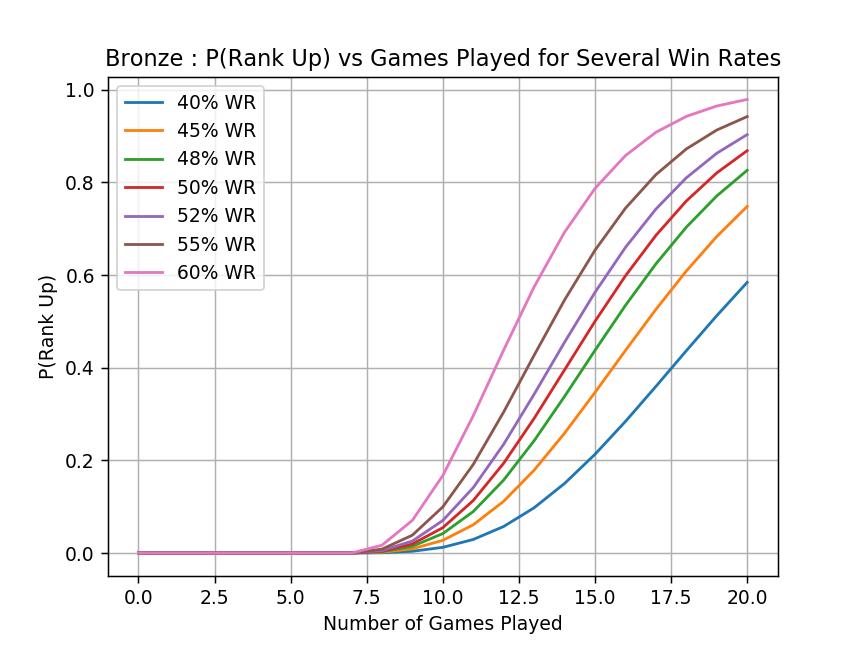

<IPython.core.display.Javascript object>


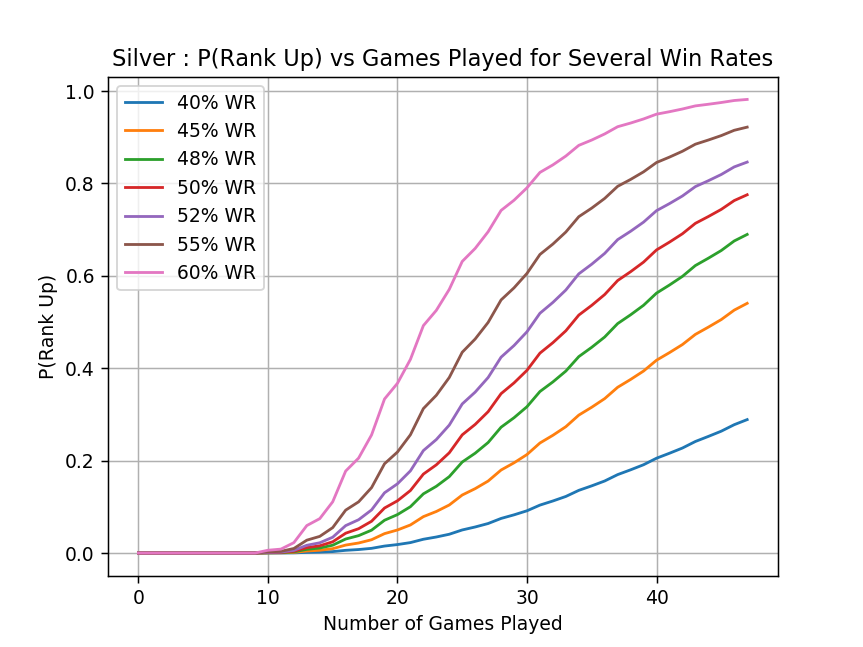

<IPython.core.display.Javascript object>


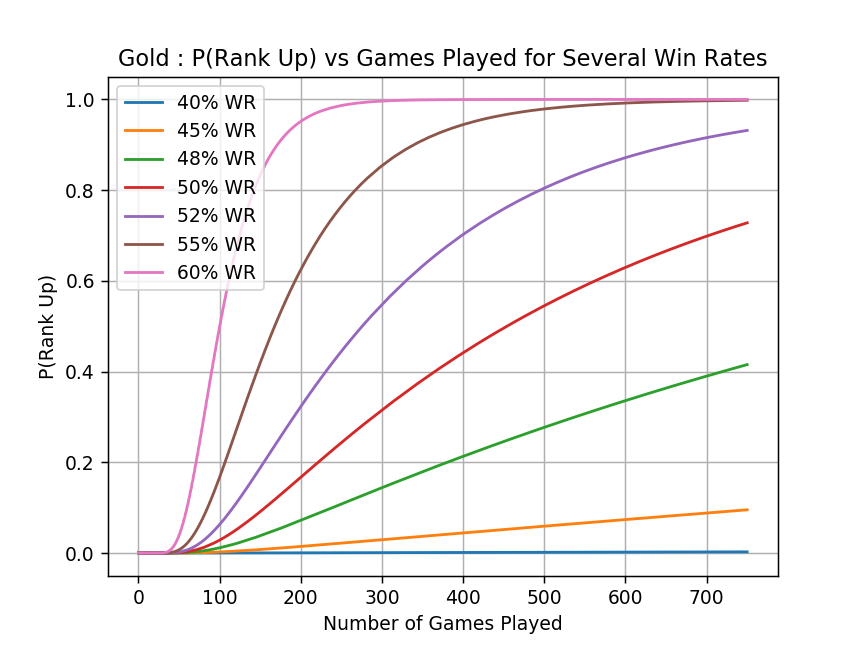

<IPython.core.display.Javascript object>


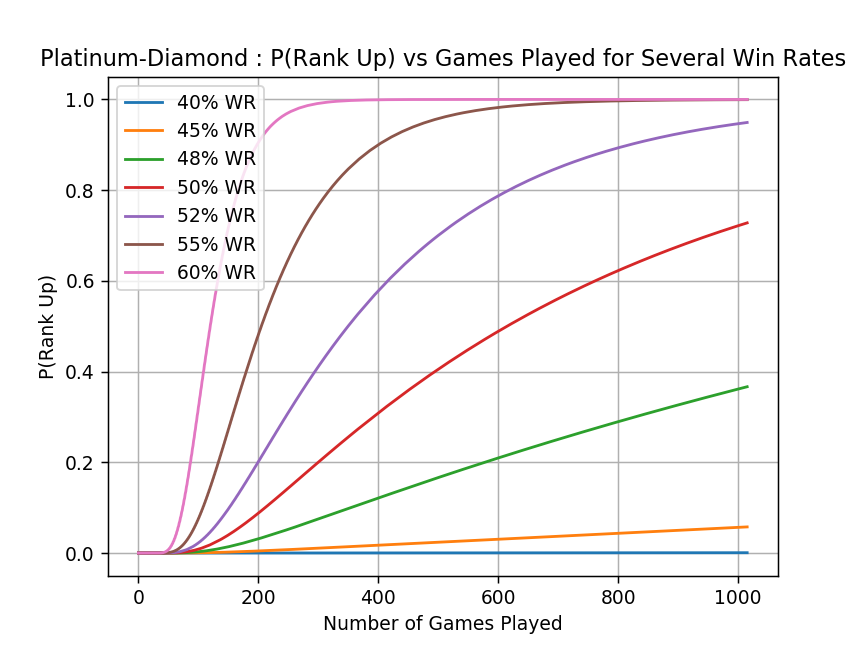

In [5]:
plot_winrates = [0.4, 0.45, 0.48, 0.5, 0.52, 0.55, 0.6]
for rank in rank_info:
    ev_num_games = ev_next_rank(create_TSD(winrate=0.5, **rank_info[rank]))[0]
    steps = [1] * int(round(ev_num_games * 1.25))
    ngames = [0] + list(np.cumsum(steps))
    df = pd.DataFrame({'Number of Games Played': ngames})
    for wr in plot_winrates:
        tsd = create_TSD(wr, **rank_info[rank])
        df[f'{wr*100:0.0f}% WR'] = next_rank_probs(tsd, steps)
    df = df.set_index('Number of Games Played')
    df.plot()
    plt.ylabel('P(Rank Up)')
    plt.title(f'{rank} : P(Rank Up) vs Games Played for Several Win Rates')
    plt.grid()
    plt.savefig(f'p_rank_up_{rank}.png')

#### Pretty DataFrame for Further Analysis

In [6]:
rank = 'Bronze'
plot_winrates = [0.4, 0.45, 0.48, 0.5, 0.52, 0.55, 0.6]
ev_num_games = ev_next_rank(create_TSD(winrate=0.5, **rank_info[rank]))[0]
steps = [1] * int(round(ev_num_games * 1.25))
ngames = [0] + list(np.cumsum(steps))
df = pd.DataFrame({'Number of Games Played': ngames})
for wr in plot_winrates:
    tsd = create_TSD(wr, **rank_info[rank])
    df[wr] = next_rank_probs(tsd, steps)

df = df.set_index('Number of Games Played')
df

,0.4,0.45,0.48,0.5,0.52,0.55,0.6
Number of Games Played,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000655,0.001682,0.002818,0.003906,0.005346,0.008373,0.016796


#### WinRate vs Average Number of Games to Rank Up

In [7]:
plot_winrates = [x/100 for x in range(40, 61)]
steps = [1] * int(round(ev_num_games * 1.25))
ngames = [0] + list(np.cumsum(steps))
df = pd.DataFrame({'winrate': plot_winrates})
for rank in rank_info:
    df[rank] = [ev_next_rank(create_TSD(winrate=wr, **rank_info[rank]))[0] for wr in plot_winrates]
df = df.set_index('winrate')

<IPython.core.display.Javascript object>


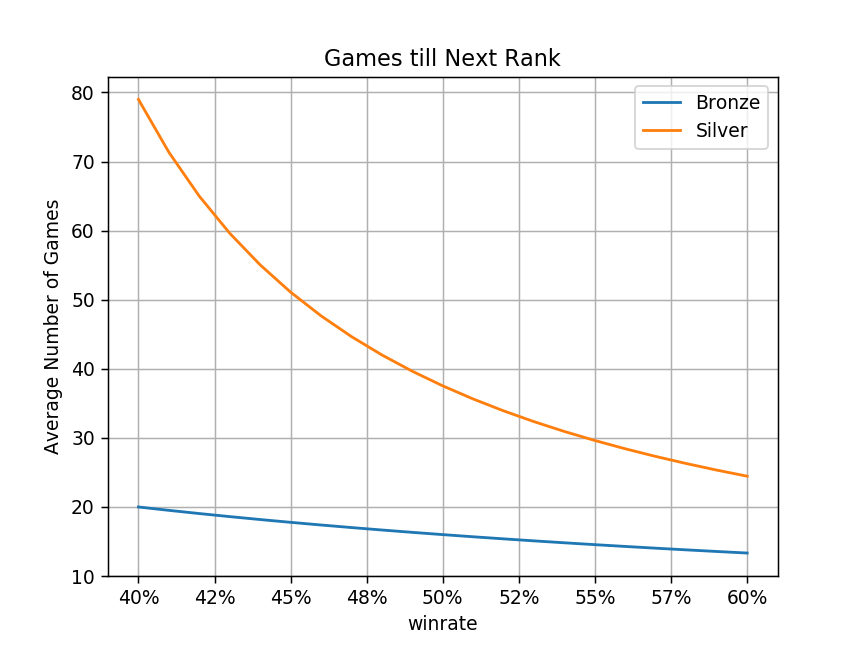

<IPython.core.display.Javascript object>


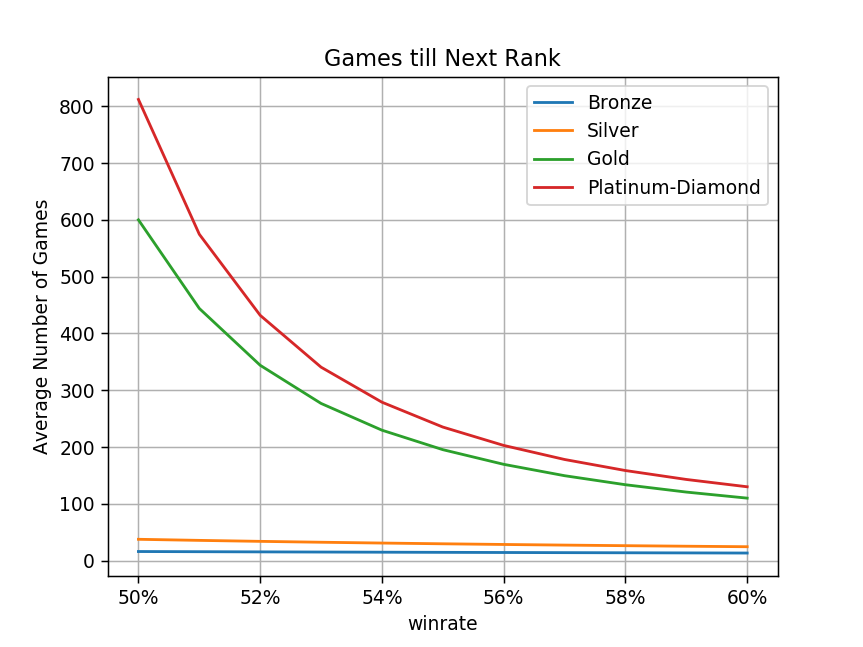

In [8]:
ax = df[['Bronze', 'Silver']].plot()
plt.title('Games till Next Rank')
ax.set_xticklabels(['{:.0%}'.format(x) for x in ax.get_xticks()])
plt.ylabel('Average Number of Games')
plt.grid()
plt.savefig('games_til_rank_Low.png')

ax = df.iloc[-11:, :].plot()
plt.title('Games till Next Rank')
ax.set_xticklabels(['{:.0%}'.format(x) for x in ax.get_xticks()])
plt.ylabel('Average Number of Games')
plt.grid()
_ = plt.savefig('games_til_rank_High.png')

#### Pretty DataFrame for Further Analysis

In [9]:
df['Platinum'] = df['Platinum-Diamond']
df['Diamond'] = df['Platinum-Diamond']
df = df[[x for x in df.columns if(x != 'Platinum-Diamond')]]
df

,Bronze,Silver,Gold,Platinum,Diamond
winrate,,,,,
0.40,20.000000,78.983532,252376.682940,1.278185e+06,1.278185e+06
0.41,19.512195,71.342837,113073.558525,4.853554e+05,4.853554e+05
0.42,19.047619,64.979517,52244.916209,1.904325e+05,1.904325e+05
0.43,18.604651,59.613218,24997.856195,7.757421e+04,7.757421e+04
0.44,18.181818,55.036343,12451.471259,3.302556e+04,3.302556e+04
0.45,17.777778,51.092874,6496.518793,1.482041e+04,1.482041e+04
0.46,17.391304,47.663902,3573.627473,7.082196e+03,7.082196e+03
0.47,17.021277,44.657589,2084.533942,3.641681e+03,3.641681e+03
0.48,16.666667,42.002124,1294.084864,2.031485e+03,2.031485e+03


#### Example of Further Analysis

In [10]:
winrate = 0.55
print(f'Getting from Bronze 4 to mythic with a {winrate*100:0.1f}% win rate takes on average {sum(df.loc[0.55]):0.1f} games')

Getting from Bronze 4 to mythic with a 55.0% win rate takes on average 709.9 games


In [11]:
sum(df.loc[0.6].iloc[:])

407.78832750462317